In [6]:
from typing import Union
from urllib.parse import unquote, quote
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import inchi
from rdkit.Chem.MolStandardize import rdMolStandardize
import pickle
from mordred import Calculator, descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors as Descriptors
import os
from rdkit import Chem
from rdkit import RDPaths
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolDraw2DSVG

from bokeh.plotting import ColumnDataSource, figure, output_file, show
from sklearn.decomposition import PCA
from bokeh.io import output_notebook

from molvs import standardize_smiles
import pandas as pd
from rdkit.Chem import inchi
from rdkit import Chem

import shap
shap.initjs()

def standardized_smiles(value):
    #print(value)
    try: return standardize_smiles(value)
    except: return "Cannot_do"
    
def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))


def MACCSKeysFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMACCSKeysFingerprint(x))

def get_num_charged_atoms_neg(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) <= 0:
            negative += 1
     
    return negative

def get_num_charged_atoms_pos(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) >= 0:
            positive += 1
    return positive

def get_assembled_ring(mol):
    ring_info = mol.GetRingInfo()
    num_ring = ring_info.NumRings()
    ring_atoms = ring_info.AtomRings()
    num_assembled = 0
     
    for i in range(num_ring):
        for j in range(i+1, num_ring):
            x = set(ring_atoms[i])
            y = set(ring_atoms[j])
            if not x.intersection(y): # 2つの環が縮環でない場合に
                for x_id in x:
                    x_atom = mol.GetAtomWithIdx(x_id)
                    neighbors = [k.GetIdx() for k in x_atom.GetNeighbors()]
                    for x_n in neighbors:
                        if x_n in y: # 環同士を繋ぐ結合があるか否か
                            num_assembled += 1
     
    return num_assembled

def get_num_stereocenters(mol):
    return AllChem.CalcNumAtomStereoCenters(mol) + AllChem.CalcNumUnspecifiedAtomStereoCenters(mol)

def calc_descriptors(dataframe):
    mols = dataframe.smiles_r.apply(Chem.MolFromSmiles)
    #mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in mols]
    descr = []
    for m in mols:
        descr.append([Descriptors.TPSA(m),
               Descriptors.NumRotatableBonds(m),
               AllChem.CalcNumRings(m),
               Descriptors.NumAromaticRings(m),
               Descriptors.NumHAcceptors(m),
               Descriptors.NumHDonors(m),
               Descriptors.FractionCSP3(m),
               Descriptors.MolLogP(m) ,
               Descriptors.NHOHCount(m),
               Descriptors.NOCount(m),
               Descriptors.NumHeteroatoms(m),
               get_num_charged_atoms_pos(m),
               get_num_charged_atoms_neg(m),
               get_assembled_ring(m),
               get_num_stereocenters(m)])
    descr = np.asarray(descr)
    return(descr)

descs = [ 'PSA', 'n_rot_bonds', 'n_rings', 'n_ar_rings',
         'n_HBA', 'n_HBD', 'Fsp3', 'logP', 'NHOHCount', 'NOCount', 'NumHeteroatoms',
        'n_positive', '_n_negative', 'n_ring_asmbl', 'n_stereo']

def calc_all_fp_desc(data):
   
    calc = Calculator(descriptors, ignore_3D=True)
    print(len(calc.descriptors))
    Ser_Mol = data['smiles_r'].apply(Chem.MolFromSmiles)
    # as pandas
    Mordred_table=  calc.pandas(Ser_Mol)
    Mordred_table = Mordred_table.astype('float')
    #Mordred_table['smiles_r'] = model_tox_data['smiles_r']
    
    MACCSfingerprint_array = np.stack(data['smiles_r'].apply(MACCSKeysFingerprint))
    MACCS_collection = []
    for x in np.arange(MACCSfingerprint_array.shape[1]):
        x = "MACCS"+str(x)
        MACCS_collection.append(x)
    MACCSfingerprint_table = pd.DataFrame(MACCSfingerprint_array, columns=MACCS_collection)


    MorganFingerprint_array = np.stack(data['smiles_r'].apply(MorganFingerprint))
    Morgan_fingerprint_collection = []
    for x in np.arange(MorganFingerprint_array.shape[1]):
        x = "Mfp"+str(x)
        Morgan_fingerprint_collection.append(x)
    Morgan_fingerprint_table = pd.DataFrame(MorganFingerprint_array, columns=Morgan_fingerprint_collection)

    
    a=calc_descriptors(data)
    descdf=pd.DataFrame(a, columns=descs)
    descdf_approved=descdf.reset_index(drop=True)
    descdf_approved
    
    tox_model_data= pd.concat([data, Morgan_fingerprint_table, MACCSfingerprint_table, descdf_approved, Mordred_table], axis=1)
    tox_model_data
    
    return(tox_model_data)
    
    
liv_data = [ "2",  "3",  "5",  "6",  "7",  "8",   "10", "11", "14", "15", "16"]

def predict_individual_liv_data(data_dummy, features, endpoint):#predict animal data
    
    loaded_rf = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))
    X = data_dummy[features]
    X = X.values
    y_proba =  loaded_rf.predict_proba(X)[:,1]  
    
    return(y_proba)

def predict_individual_cmax_data(data_dummy, features, endpoint):#predict animal data
    
    regressor = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))

    X = data_dummy[features]
    X = X.values
    #Add predictions to held out test set dili
    y_pred = regressor.predict(X)
    
    return(y_pred)

def predict_liv_all(data):
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    data_dummy = data

    for endpoint in liv_data:
        #print(endpoint)
        y_proba = predict_individual_liv_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
        
    for endpoint in ["median pMolar unbound plasma concentration" ,
               "median pMolar total plasma concentration"]:
        y_proba = predict_individual_cmax_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
    
    return(data)


def predict_DILI(data):#log human_VDss_L_kg model
    
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    features = list(features) + ["median pMolar unbound plasma concentration", "median pMolar total plasma concentration"] + list(liv_data) 
    loaded_rf = pickle.load(open("./final_dili_model.sav", 'rb'))
    #Note this mode was trained on all data before releasing (not just ncv data)

    X = data[features]
    y_proba =  loaded_rf.predict_proba(X)[:,1]
    best_thresh = 0.612911
    print('Best Threshold=%f' % (best_thresh))
    
    y_pred  = [ 1 if y_proba>best_thresh  else 0] 
    
    explainer = shap.TreeExplainer(loaded_rf)
    shap_values = explainer.shap_values(X)
    

    shap.force_plot(explainer.expected_value[1], 
    shap_values[1], X.iloc[0],
    matplotlib=True)
    
    
    flat_shaplist = [item for sublist in shap_values[1] for item in sublist]
    
    interpret = pd.DataFrame()
    interpret["name"] = features
    interpret["SHAP"] = flat_shaplist#print(flat_shaplist)
    plt.show()
    # Explaining the 4th instance

    return(interpret, y_proba, y_pred)


def mol2svg(mol):
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

source = ["Liver Toxicity Knowledge Base",
"Human hepatotoxicity",
"Animal hepatotoxicity A",
"Animal hepatotoxicity B",
"Preclinical hepatotoxicity",
"Diverse DILI A",
"Diverse DILI B",
"Diverse DILI C",
"BESP",
"Mitotox",
"Reactive Metabolite"]


assaytype = ["DILI",
"Human hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Heterogenous Data ",
"Heterogenous Data ",
"Heterogenous Data ",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity"]


info = pd.DataFrame({"name": liv_data, "source": source, "assaytype": assaytype})
info

name                         source                     assaytype
0     2  Liver Toxicity Knowledge Base                          DILI
1     3           Human hepatotoxicity          Human hepatotoxicity
2     5        Animal hepatotoxicity A         Animal hepatotoxicity
3     6        Animal hepatotoxicity B         Animal hepatotoxicity
4     7     Preclinical hepatotoxicity         Animal hepatotoxicity
5     8                 Diverse DILI A            Heterogenous Data 
6    10                 Diverse DILI B            Heterogenous Data 
7    11                 Diverse DILI C            Heterogenous Data 
8    14                           BESP  Mechanisms of Liver Toxicity
9    15                        Mitotox  Mechanisms of Liver Toxicity
10   16            Reactive Metabolite  Mechanisms of Liver Toxicity

In [7]:
#Add your SMILES representation here
smiles_list = ["CCCCOCCO"]

In [8]:
    for s in smiles_list:
        smiles = unquote(s)
    
        smiles_r = standardized_smiles(smiles)
        test = {'smiles_r':  [smiles_r]
                    }
        test = pd.DataFrame(test)

        desc=pd.read_csv("all_features_desc.csv", encoding='windows-1252')


        molecule = Chem.MolFromSmiles(smiles_r)     
        #st.image(Draw.MolToImage(molecule), width=200)
                
        test_mfp_Mordred = calc_all_fp_desc(test)
        test_mfp_Mordred_liv = predict_liv_all(test_mfp_Mordred)
        test_mfp_Mordred_liv_values = test_mfp_Mordred_liv.T.reset_index().rename(columns={"index":"name", 0: "value"})

        interpret, y_proba, y_pred = predict_DILI(test_mfp_Mordred_liv)   
        interpret = pd.merge(interpret, desc, right_on="name", left_on="name", how="outer")
        interpret = pd.merge(interpret, test_mfp_Mordred_liv_values, right_on="name", left_on="name", how="inner") 

        print(y_proba[0])
        print(y_pred[0]) 
        
        if(y_pred[0]==1):
            print("The compound is predicted DILI-Positive")
        if(y_pred[0]==0):
            print("The compound is predicted DILI-Negative")
        
        print("unbound Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar unbound plasma concentration"][0] *10**6, 2), "uM")
        print("total Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar total plasma concentration"][0] *10**6, 2), "uM")
        print("Most contributing MACCS substructure to DILI toxicity")
        
        top = interpret[interpret["SHAP"]>0].sort_values(by=["SHAP"], ascending=False)
        proxy_DILI_SHAP_top = pd.merge(info, top[top["name"].isin(liv_data)])
        proxy_DILI_SHAP_top["pred"] = proxy_DILI_SHAP_top["value"]>0.50
        proxy_DILI_SHAP_top["SHAP contribution to Toxicity"] = "Positive"
        proxy_DILI_SHAP_top["smiles"] = smiles_r
        
        top_positives = top[top["value"]==1]
        top_MACCS= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        top_MACCS_value= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        top_MACCS_shap= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0] 
        top_MACCSsubstructure = Chem.MolFromSmarts(top_MACCS)
        
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(top_MACCSsubstructure), width=400)        
        print("Presence of this substructure contributes", np.round(top_MACCS_shap, 4), "to prediction")
                     
                 
        print("Most contributing MACCS substructure to DILI safety")
        bottom = interpret[interpret["SHAP"]<0].sort_values(by=["SHAP"], ascending=True)
        proxy_DILI_SHAP_bottom = pd.merge(info, bottom[bottom["name"].isin(liv_data)])
        proxy_DILI_SHAP_bottom["pred"] = proxy_DILI_SHAP_bottom["value"]>0.50
        proxy_DILI_SHAP_bottom["SHAP contribution to Toxicity"] = "Negative"
        proxy_DILI_SHAP_bottom["smiles"] = smiles_r
        
        bottom_positives = bottom[bottom["value"]==1]
        bottom_MACCS= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        bottom_MACCS_value= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        bottom_MACCS_shap= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0]     
        bottom_MACCSsubstructure = Chem.MolFromSmarts(bottom_MACCS)
                 
                                  
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(bottom_MACCSsubstructure), width=400) 
        print("Presence of this substructure contributes", np.round(bottom_MACCS_shap, 4), "to prediction")

1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.78it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'bestlivmodel_2_model.sav'

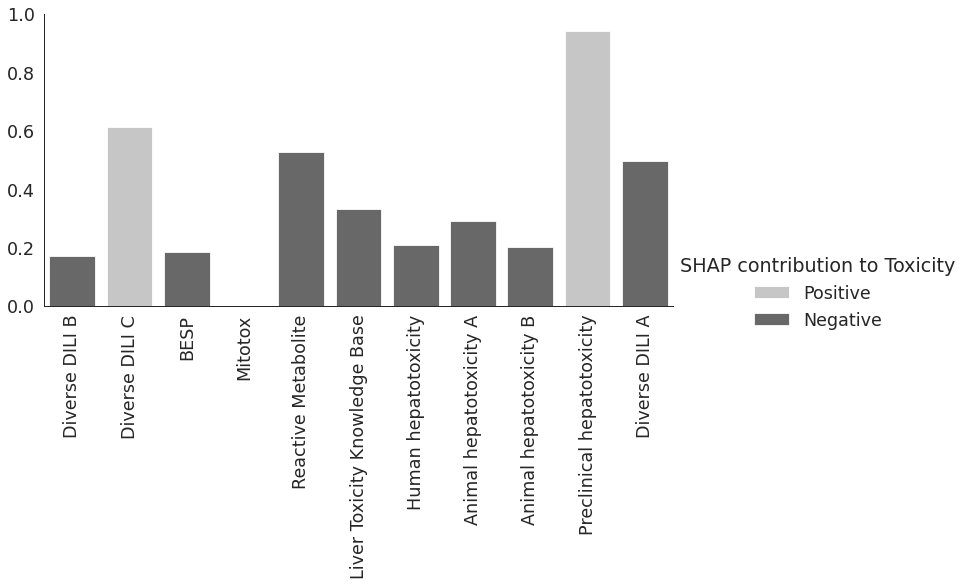

In [9]:
import seaborn as sns
SHAP =pd.DataFrame(columns=['name', 'source', 'assaytype', 'SHAP', 'description', 'value', 'pred','influence', 'smiles'])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_top])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_bottom])
SHAP["name"] = SHAP["name"].astype(str)
SHAP = SHAP.sort_values(by=["name"], ascending=True)
#fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.set_style('white')
sns.set_context('paper', font_scale=2)
hue_order = ['Positive', 'Negative']
#sns.barplot(data=compound, x="source", y="value", color='grey')
g = sns.catplot(data=SHAP, x="source", y="value", kind="bar", hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                palette="Greys", height=5, aspect=2, dodge=False, legend=True)
#plt.axhline(y=0.5, color='r', linestyle='--')
g.set_xticklabels(rotation=90)
g.set(ylabel=None)
g.set(xlabel=None)
g.set(ylim=(0, 1))
plt.show()

In [26]:
SHAP

name                         source                     assaytype      SHAP  \
5   10                 Diverse DILI B            Heterogenous Data  -0.009957   
1   11                 Diverse DILI C            Heterogenous Data    0.00517   
6   14                           BESP  Mechanisms of Liver Toxicity -0.006261   
7   15                        Mitotox  Mechanisms of Liver Toxicity  -0.00922   
8   16            Reactive Metabolite  Mechanisms of Liver Toxicity -0.002765   
0    2  Liver Toxicity Knowledge Base                          DILI -0.026408   
1    3           Human hepatotoxicity          Human hepatotoxicity -0.025325   
2    5        Animal hepatotoxicity A         Animal hepatotoxicity -0.000809   
3    6        Animal hepatotoxicity B         Animal hepatotoxicity  -0.00577   
0    7     Preclinical hepatotoxicity         Animal hepatotoxicity  0.032516   
4    8                 Diverse DILI A            Heterogenous Data  -0.000673   

                                         description     value   pred  \
5  US drug-induced liver injury network (DILIN) ,...   0.16936  False   
1  Transient liver function abnormalities, advers...  0.612087   True   
6              BESP Bile Salt Export Pump Inhibition  0.183858  False   
7                                           Mitotox   0.000059  False   
8                      Reactive Metabolite Formation  0.526413   True   
0  Liver Toxicity Knowledge Base (LTKB), prescrip...  0.332425  False   
1                Human hepatotoxicity, hepatobiallry  0.208494  False   
2  Rat, chronic oral administration, Hepatic hist...  0.290003  False   
3       Hepatocellular hypertrophy, rats, ORAD, HESS   0.20096  False   
0  Preclinical hepatotoxicity data from PharmaPen...  0.941045   True   
4  Large-scale and diverse ddrug induced liver in...  0.496632  False   

  influence    smiles SHAP contribution to Toxicity  
5       NaN  CCCCOCCO                      Negative  
1       NaN  CCCCOCCO                      Positive  
6       NaN  CCCCOCCO                      Negative  
7       NaN  CCCCOCCO                      Negative  
8       NaN  CCCCOCCO                      Negative  
0       NaN  CCCCOCCO                      Negative  
1       NaN  CCCCOCCO                      Negative  
2       NaN  CCCCOCCO                      Negative  
3       NaN  CCCCOCCO                      Negative  
0       NaN  CCCCOCCO                      Positive  
4       NaN  CCCCOCCO                      Negative

In [35]:
compound = SHAP[SHAP["smiles"]==smiles].sort_values(by=["name"], ascending=True)
pos= compound[compound["SHAP"]>0].sort_values(by="SHAP", ascending=False)
neg = compound[compound["SHAP"]<0].sort_values(by="SHAP", ascending=True)
    
print(pos["source"][:3])
print(neg["source"][:3])
    
  

0    Preclinical hepatotoxicity
1                Diverse DILI C
Name: source, dtype: object
0    Liver Toxicity Knowledge Base
1             Human hepatotoxicity
5                   Diverse DILI B
Name: source, dtype: object


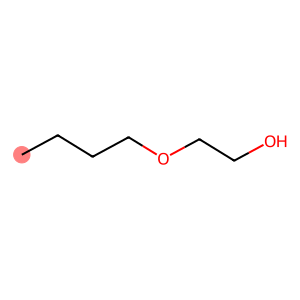

In [43]:
m = Chem.MolFromSmiles(smiles)
Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(bottom_MACCSsubstructure), width=200)  

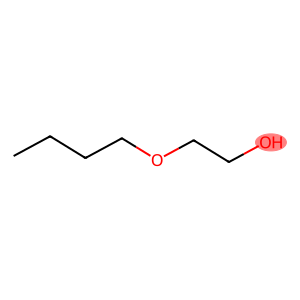

In [44]:
m = Chem.MolFromSmiles(smiles)
Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(top_MACCSsubstructure), width=200)  